In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [6]:
def preview_dataset(dataset, num_images=8):
    """
    Displays a grid of images with their class labels.

    Args:
    - dataset: The dataset to preview, e.g., train_dataset.
    - num_images: Number of images to display (default is 8).
    """
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    images = torch.clamp(images, 0, 1)

    # Plot images in a grid
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        ax = plt.subplot(2, num_images // 2, i + 1)
        np_img = images[i].numpy().transpose((1, 2, 0))  # Convert from Tensor to NumPy array
        plt.imshow(np_img)
        plt.title(dataset.classes[labels[i].item()])
        plt.axis("off")
    plt.show()

In [7]:
num_epochs = 10
batch_size = 32
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet standard input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet stats
])

In [10]:
train_dataset = datasets.ImageFolder(root="/home/hbdesk/labelstudio_convert/weapon_img/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [15]:
print(train_dataset.classes)

['ACE32', 'AKM', 'AUG_A3', 'AWM', 'BERYL_M762', 'DBS', 'DRAGUNOV', 'FIST', 'FRAG_NADE', 'G36C', 'GROZA', 'K98K', 'LYNX_AMR', 'M16A4', 'M24', 'M249', 'M416', 'MICRO_UZI', 'MINI_14', 'MK12', 'MK14_EBR', 'MK47_MUTANT', 'MOLOTOV', 'MOSIN_NAGANT', 'MP5K', 'P90', 'PANZERFAUST', 'PP_19', 'QBU', 'QBZ95', 'S12K', 'S1897', 'S686', 'SAWED_OFF', 'SCAR_L', 'SKS', 'SLR', 'TOMMY', 'UMP45', 'VECTOR', 'VSS_VINTOREZ']


In [ ]:
with open('./weapons_list.txt', 'w') as file:
    file.write('\n'.join(train_dataset.classes))

In [11]:
model = models.resnet34(pretrained=True)
num_classes = len(train_dataset.classes)  # automatically detect number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final layer
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/home/hbdesk/pubg_parser/weapons_classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hbdesk/pubg_parser/weapons_classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/hbdesk/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100.0%


In [12]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Calculate and print average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the model checkpoint
torch.save(model.state_dict(), "weapon_classifier.pth")
print("Training complete. Model saved.")

Epoch [1/10], Loss: 0.6918
Epoch [2/10], Loss: 0.2037
Epoch [3/10], Loss: 0.1452
Epoch [4/10], Loss: 0.1078
Epoch [5/10], Loss: 0.0750
Epoch [6/10], Loss: 0.0596
Epoch [7/10], Loss: 0.0618
Epoch [8/10], Loss: 0.0837
Epoch [9/10], Loss: 0.0933
Epoch [10/10], Loss: 0.0689
Training complete. Model saved.


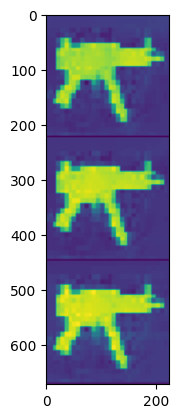

Predicted class: MP5K


In [14]:
from PIL import Image
import torch
from torchvision import transforms

# Define the image preprocessing transform
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to load the trained model
def load_model(model_path, num_classes):
    model = models.resnet34(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()  # Set model to evaluation mode
    return model

# Inference function
def predict(image_path, model, class_names):
    """
    Perform inference on a single image.

    Args:
    - image_path (str): Path to the input image.
    - model (torch.nn.Module): Trained PyTorch model.
    - class_names (list of str): List of class names.

    Returns:
    - str: Predicted class name.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image)
    # print(type(input_tensor))
    plt.imshow(input_tensor.view(-1, 224).cpu().numpy())
    plt.show()
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    # Move the input to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    model = model.to(device)

    # Perform inference
    with torch.no_grad():
        output = model(input_batch)
        _, predicted_idx = torch.max(output, 1)

    # Get the class label
    predicted_class = class_names[predicted_idx.item()]
    return predicted_class

# Load the model and class names
model_path = "./weapon_classifier.pth"
class_names = train_dataset.classes
model = load_model(model_path, num_classes=len(class_names))

# Perform inference on an example image
image_path = "/home/hbdesk/Pictures/Selection_123.png"  # Replace with your image path
predicted_class = predict(image_path, model, class_names)
print(f"Predicted class: {predicted_class}")